## Northeastern University Open Sports Data & Analytics Conference Getting 
### Started with IMPECT Open Event Data and [Kloppy](https://kloppy.pysport.org/) (powered by [PySport](https://pysport.org/))

### Install Packages:
- Download Python3.11+ if you don't have it already.
- Make a virtual environment to store and install all the Python packages related to this project.
- Activate the virtual environment (select it as a Kernel for this Jupyter Notebook)

Install the following package to use this notebook:

### Kloppy

Kloppy is _the_ industry standard open-source soccer data standardization package used by clubs in the English Premier League, Italian Seria A, La Liga, German BundesLiga, Major League Soccer, Dutch Eredivisie etc etc. It is used to standardize data from different data providers into a single format, because each data provider uses its own proprietary formats, event definitions and coordinate systems.

We can use Kloppy to directly load and access [Open IMPECT Event Data](https://github.com/ImpectAPI/open-data).

### IMPECT Open Event Data

[IMPECT](https://www.impect.com/en/) is a big data provider that offers free data event data for the 2023/24 Bundesliga season, available for research purposes.

### 306 Bundesliga Games

We can easily access and see all publicly available competitions using the functionality below. 

1. We load the [**matches file**](https://github.com/ImpectAPI/open-data/blob/main/data/matches/matches_743.json) and the [**squads file**](https://github.com/ImpectAPI/open-data/blob/main/data/squads/squads_743.json) directly from GitHub. 
2. We remove, rename and unpack (unnest) the json files using [**Polars**](https://pola.rs/), an improved and faster alternative to Pandas, to obtain `matches` and `squads`

In [2]:
import polars as pl
import requests
import io

from kloppy.utils import github_resolve_raw_data_url

# 1. Load matches and squads data from IMPECT Open Data repository
match_url = github_resolve_raw_data_url(
    repository="ImpectAPI/open-data",
    branch="main",
    file="data/matches/matches_743.json"
)
squads_url = github_resolve_raw_data_url(
    repository="ImpectAPI/open-data",
    branch="main",
    file="data/squads/squads_743.json"
)

# 2. Load and process matches data
response = requests.get(match_url)
matches = (
    pl.read_json(io.StringIO(response.text))
    .unnest("matchDay")
    .rename({'iterationId': 'competitionId', 'id': 'matchId'})
    .drop(['idMappings', 'lastCalculationDate', 'name', 'available'])
    .with_columns([
        (pl.col("index") + 1).alias("matchDay")
    ])
    .drop("index")
)

response = requests.get(squads_url)
squads = (
    pl.read_json(io.StringIO(response.text))
    .drop(['type', 'gender', 'imageUrl', 'idMappings', 'access', 'countryId'])
)


3. We combine `matches` with `squads` to know the `homeTeam` and `awayTeam` names, which we obtain from the `squads` file.

In [3]:
matches = (
    matches
    .join(
        squads.rename({"name": "homeTeam"}),
        left_on="homeSquadId",
        right_on="id",
        how="left"
    )
    .join(
        squads.rename({"name": "awayTeam"}),
        left_on="awaySquadId",
        right_on="id",
        how="left"
    )
)

matches

competitionId,matchId,homeSquadId,awaySquadId,scheduledDate,matchDay,homeTeam,awayTeam
i64,i64,i64,i64,str,i64,str,str
743,122838,38,33,"""2023-08-18T18:30:00Z""",1,"""SV Werder Bremen""","""FC Bayern München"""
743,122839,41,37,"""2023-08-19T13:30:00Z""",1,"""Bayer 04 Leverkusen""","""RasenBallsport Leipzig"""
743,122840,30,432,"""2023-08-19T13:30:00Z""",1,"""VfL Wolfsburg""","""1. FC Heidenheim 1846"""
743,122841,31,34,"""2023-08-19T13:30:00Z""",1,"""TSG 1899 Hoffenheim""","""SC Freiburg"""
743,122842,46,416,"""2023-08-19T13:30:00Z""",1,"""VfB Stuttgart""","""VfL Bochum"""
…,…,…,…,…,…,…,…
743,123139,46,32,"""2024-05-18T13:30:00Z""",34,"""VfB Stuttgart""","""Borussia Mönchengladbach"""
743,123140,432,27,"""2024-05-18T13:30:00Z""",34,"""1. FC Heidenheim 1846""","""1. FC Köln"""
743,123141,38,416,"""2024-05-18T13:30:00Z""",34,"""SV Werder Bremen""","""VfL Bochum"""


Now, we can load one game at a time using Kloppy's `impect.load_open_data` functionality.

In [4]:
from kloppy import impect

match_id = 122838 
dataset = impect.load_open_data(
    match_id=match_id,
    competition_id=743,
)


/opt/anaconda3/lib/python3.12/site-packages/kloppy/_providers/impect.py:88: UserWarning: 

You are about to use IMPECT public data.
By using this data, you are agreeing to the user agreement. 
The user agreement can be found here: https://github.com/ImpectAPI/open-data/blob/main/LICENSE.pdf

  warnings.warn(


In [5]:
dataset

<EventDataset record_count=3057>

### Basic Kloppy Operations

- Transform the [**coordinate system**](https://kloppy.pysport.org/user-guide/concepts/coordinates/) to meters and such that X $\in$ (-52.5, 52.5) and Y $\in$ (-34.0, 34.0) [called "secondspectrum"].
    Note: kloppy supports many different coodinate systems, and even custom coordinate systems.
- Filter for Passes and Shots
- Output to [Polars](https://pola.rs/) dataframe

In [17]:
df = (
    dataset
    .transform(to_coordinate_system="statsbomb")  
    .filter(lambda event: event.event_type.name in ["PASS", "SHOT"])
    .to_df(engine="pandas")
)

df.head()

,event_id,event_type,period_id,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,body_part_type,set_piece_type,result,success,pass_type,is_under_pressure
0,4858179098,PASS,1,0 days 00:00:00,0 days 00:00:00.332000,alive,33,33,204,60.000000,40.000000,NaN,NaN,None,RIGHT_FOOT,KICK_OFF,INCOMPLETE,False,None,None
1,4858179102,PASS,1,0 days 00:00:04.192999,0 days 00:00:06.904999,alive,33,33,1202,23.750000,40.109290,75.129310,8.063584,None,RIGHT_FOOT,None,INCOMPLETE,False,None,None
2,4858179104,PASS,1,0 days 00:00:06.905100,0 days 00:00:08.260000,alive,33,38,1028,44.870690,71.936416,36.784483,68.164740,13599,HEAD,None,COMPLETE,True,HEAD_PASS,True
3,4858179108,PASS,1,0 days 00:00:11.740100,0 days 00:00:14.175000,alive,33,33,50321,49.577586,24.392727,49.456897,0.000000,None,HEAD,None,INCOMPLETE,False,HEAD_PASS,True
4,4858179110,PASS,1,0 days 00:00:24.350000,0 days 00:00:25.161000,alive,38,38,1028,70.543103,80.000000,75.008621,67.644509,9550,KEEPER_ARM,THROW_IN,COMPLETE,True,HAND_PASS,None


### Basic Kloppy Functionalities
- [EventDataset](https://kloppy.pysport.org/user-guide/concepts/event-data/)
- [Metadata (players, team names etc.)](https://kloppy.pysport.org/user-guide/concepts/metadata/)
- [Coordinate Systems](https://kloppy.pysport.org/user-guide/concepts/coordinates/#built-in-coordinate-systems)
- [Transformations](https://kloppy.pysport.org/user-guide/transformations/coordinates/)
- [Filter](https://kloppy.pysport.org/user-guide/getting-started/#filtering-data)
- [Exporting to pandas / polars DataFrames](https://kloppy.pysport.org/user-guide/exporting-data/dataframes/)

### Plotting

Use `mplsoccer` and `matplotlib` to plot some different configurations of tracking data.

See [Plotting Examples](https://kloppy.pysport.org/user-guide/getting-started/#exec-51--__tabbed_1_2)

In [ ]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'Pass Map')

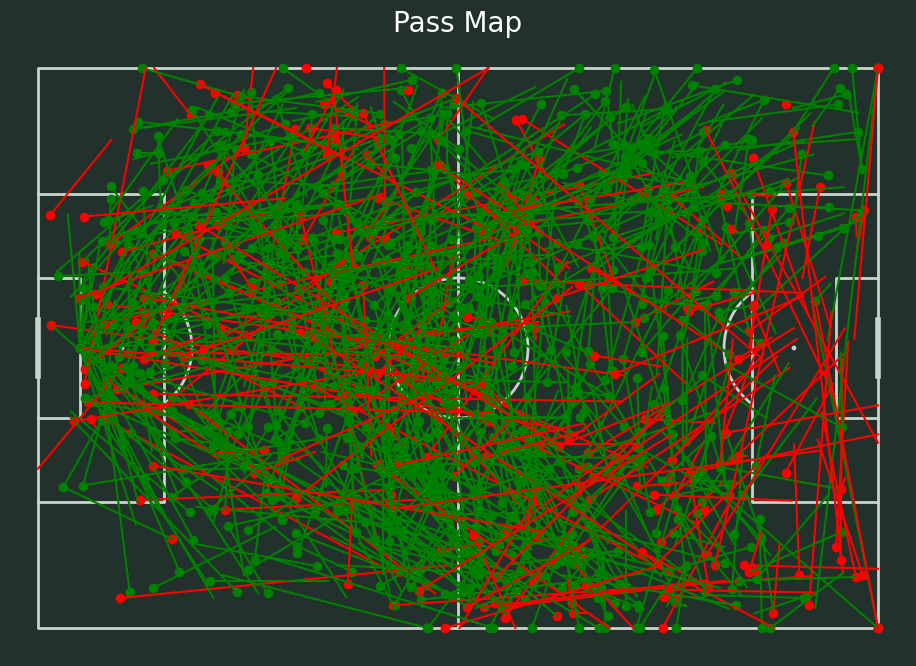

In [27]:
fig,ax = plt.subplots(figsize = (13.5, 8))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
pitch.draw(ax=ax)


for x in range(len(df)):
    if df['event_type'][x] == 'PASS':

        if df['success'][x] == True:
            plt.plot(
                [df['coordinates_x'][x], df['end_coordinates_x'][x]],
                [df['coordinates_y'][x], df['end_coordinates_y'][x]],
                color='green'
            )
            plt.scatter(
                df['coordinates_x'][x],
                df['coordinates_y'][x],
                color='green'
            )

        elif df['success'][x] == False:
            plt.plot(
                [df['coordinates_x'][x], df['end_coordinates_x'][x]],
                [df['coordinates_y'][x], df['end_coordinates_y'][x]],
                color='red'
            )
            plt.scatter(
                df['coordinates_x'][x],
                df['coordinates_y'][x],
                color='red'
            )


plt.title('Pass Map', color='white', fontsize=20)
           